# **CNN vs. ViT on CIFAR-10 (Google Colab Notebook)**

## **1. Setup & Install Dependencies**



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
from torchvision.models import resnet18
from transformers import ViTForImageClassification, ViTFeatureExtractor
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torch.cuda.amp import GradScaler, autocast


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## **2. Load and Preprocess CIFAR-10 Dataset**


In [ ]:
# Apply transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize for ViT compatibility
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
full_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Use only 10% of training data for speed optimization, othervise it was taking 2hrs for training vit model
subset_size = int(0.1 * len(full_train_dataset))  # 10% data
subset_indices = np.random.choice(len(full_train_dataset), subset_size, replace=False)
train_dataset = Subset(full_train_dataset, subset_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


download and load CIFAR-10 dataset ... train and test data


**creat dataloader**

## **3. Define CNN Model (ResNet-18)**



In [ ]:
cnn_model = resnet18(pretrained = True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
cnn_model = resnet18(pretrained=True)
cnn_model.fc = nn.Linear(512, 10)
cnn_model = cnn_model.to(device)

## **4. Define Vision Transformer Model (ViT-B/16)**

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
vit_model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224", num_labels=10 ,ignore_mismatched_sizes=True)
vit_model = vit_model.to(device)

print("Vision Transformer Model Loaded")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Vision Transformer Model Loaded


## **5. Define Loss Function & Optimizers**

In [ ]:
criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
vit_optimizer = optim.Adam(vit_model.parameters(), lr=0.0001)
scaler = GradScaler()  # Enable AMP


<ipython-input-18-30d45da09fe2>:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # Enable AMP


## **6. Define Training Function with Time Tracking**

In [ ]:
from torch.amp import autocast

def train(model, optimizer, epochs=5):
    model.train()
    start_time = time.time()
    history = {'loss': [], 'accuracy': []}

    for epoch in range(epochs):
        total_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast("cuda"):
                if isinstance(model, models.ResNet):
                    outputs = model(images)
                else:
                    outputs = model(pixel_values=images).logits

                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total += labels.size(0)

        history['loss'].append(total_loss / len(train_loader))
        history['accuracy'].append(100 * correct / total)

        print(f"Epoch {epoch+1}: Loss={history['loss'][-1]:.4f}, Accuracy={history['accuracy'][-1]:.2f}%")

    print(f"Training time: {time.time() - start_time:.2f} seconds")
    return history


## **7. Train Both Models**

In [ ]:
cnn_history = train(cnn_model, cnn_optimizer, epochs=3)
vit_history = train(vit_model, vit_optimizer, epochs=3)

Epoch 1: Loss=0.8908, Accuracy=69.36%
Epoch 2: Loss=0.4748, Accuracy=83.76%
Epoch 3: Loss=0.3152, Accuracy=88.78%
Training time: 37.59 seconds
Epoch 1: Loss=0.5062, Accuracy=87.68%
Epoch 2: Loss=0.0656, Accuracy=98.32%
Epoch 3: Loss=0.0205, Accuracy=99.68%
Training time: 117.80 seconds


## **8. Define Evaluation Function with Metrics**

In [ ]:
def evaluate(model):
    model.eval()
    correct, total = 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            if isinstance(model, models.ResNet):
                outputs = model(images)
            else:
                outputs = model(pixel_values=images).logits

            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))
    return 100 * correct / total, all_preds, all_labels


cnn_acc, cnn_preds, cnn_labels = evaluate(cnn_model)
vit_acc, vit_preds, vit_labels = evaluate(vit_model)



print(f"CNN (ResNet-18) Test Accuracy: {cnn_acc:.2f}%")
print(f"ViT Test Accuracy: {vit_acc:.2f}%")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.73      0.89      0.80      1000
           1       0.87      0.94      0.91      1000
           2       0.82      0.65      0.73      1000
           3       0.50      0.84      0.63      1000
           4       0.79      0.80      0.79      1000
           5       0.95      0.38      0.54      1000
           6       0.87      0.83      0.85      1000
           7       0.79      0.82      0.81      1000
           8       0.96      0.77      0.85      1000
           9       0.89      0.90      0.90      1000

    accuracy                           0.78     10000
   macro avg       0.82      0.78      0.78     10000
weighted avg       0.82      0.78      0.78     10000



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1000
           1       0.98      0.98      0.98      1000
           2       0.98      0.96      0.97      1000
           3       0.89      0.98      0.93      1000
           4       0.97      0.99      0.98      1000
           5       0.99      0.90      0.94      1000
           6       0.99      0.99      0.99      1000
           7       1.00      0.98      0.99      1000
           8       0.97      0.99      0.98      1000
           9       0.98      0.98      0.98      1000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

CNN (ResNet-18) Test Accuracy: 78.31%
ViT Test Accuracy: 97.22%


## **9. Confusion Matrix Visualization**

CNN Accuracy: 78.31
ViT Accuracy: 97.22


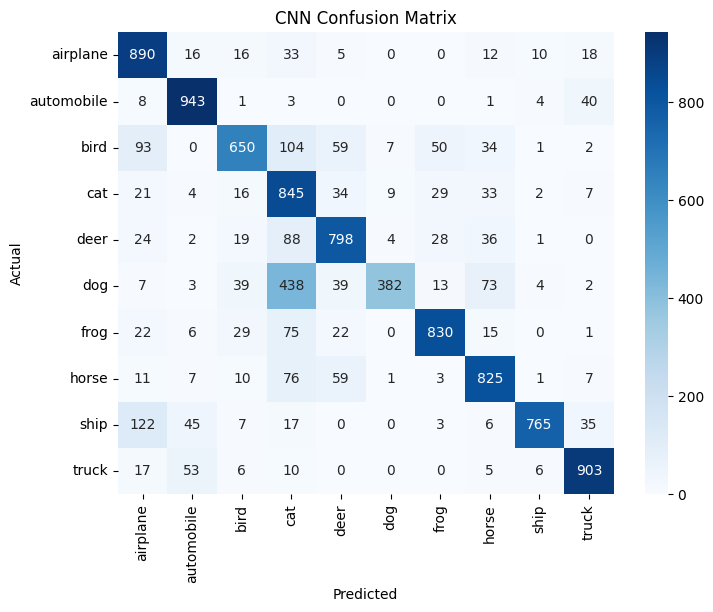

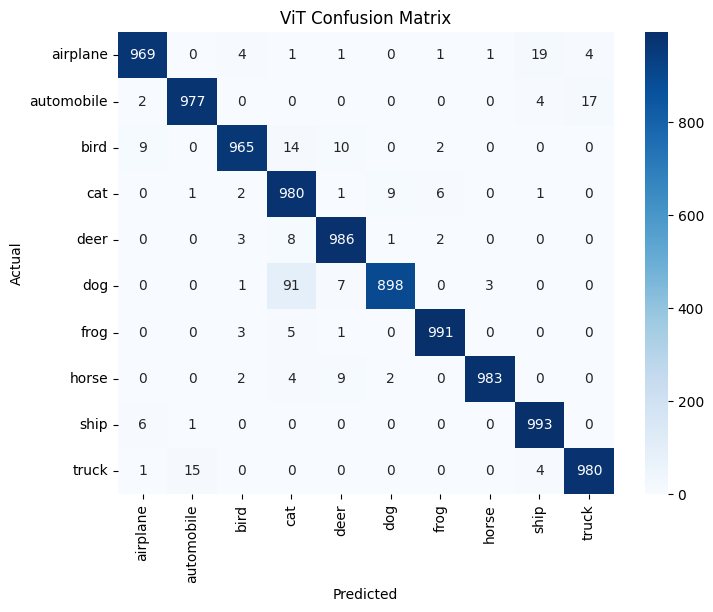

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def plot_confusion_matrix(labels, preds, title):
    cm = confusion_matrix(labels, preds)


    if cm.shape != (10, 10):
        print(f"Warning: Confusion matrix shape is {cm.shape}, expected (10,10). Check labels and predictions.")

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


print("CNN Accuracy:", cnn_acc)
print("ViT Accuracy:", vit_acc)

plot_confusion_matrix(cnn_labels, cnn_preds, "CNN Confusion Matrix")
plot_confusion_matrix(vit_labels, vit_preds, "ViT Confusion Matrix")


## **10. Plot Training Curves**

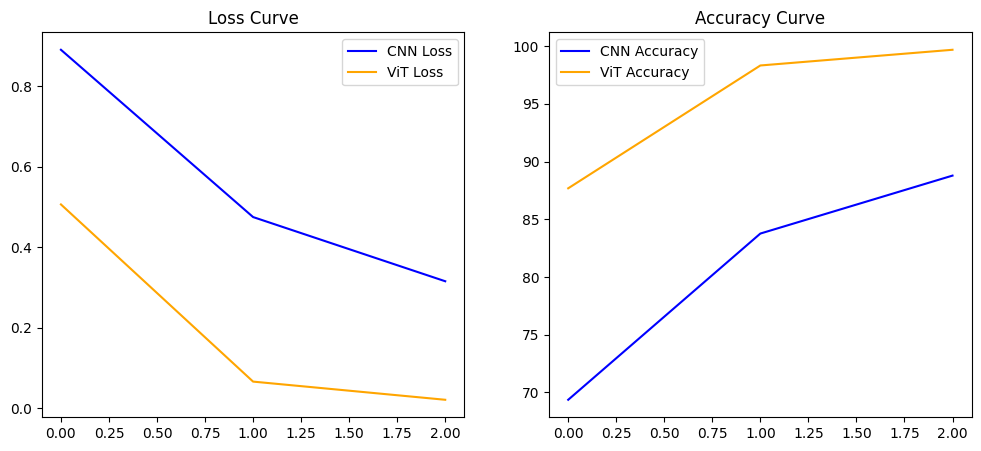

In [ ]:
def plot_training_curves(cnn_history, vit_history):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(cnn_history['loss'], label='CNN Loss', color='blue')
    plt.plot(vit_history['loss'], label='ViT Loss', color='orange')
    plt.title('Loss Curve')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(cnn_history['accuracy'], label='CNN Accuracy', color='blue')
    plt.plot(vit_history['accuracy'], label='ViT Accuracy', color='orange')
    plt.title('Accuracy Curve')
    plt.legend()
    plt.show()

plot_training_curves(cnn_history, vit_history)